In [ ]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import SGDRegressor
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import pandas as pd
import numpy as np

In [ ]:
data = pd.read_csv('/content/train_energy_data.csv')

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Building Type        1000 non-null   object 
 1   Square Footage       1000 non-null   int64  
 2   Number of Occupants  1000 non-null   int64  
 3   Appliances Used      1000 non-null   int64  
 4   Average Temperature  1000 non-null   float64
 5   Day of Week          1000 non-null   object 
 6   Energy Consumption   1000 non-null   float64
dtypes: float64(2), int64(3), object(2)
memory usage: 54.8+ KB


In [ ]:
X = data.drop('Energy Consumption', axis=1)
y = data['Energy Consumption']

In [ ]:
# splitting it in train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# check if it worked
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("Y_train shape:", y_train.shape)
print("Y_test shape:", y_test.shape)

X_train shape: (800, 6)
X_test shape: (200, 6)
Y_train shape: (800,)
Y_test shape: (200,)


In [ ]:
# preprocessing categorical and putting numerical ones on a scale
categorical_cols = ['Building Type', 'Day of Week']
numeric_cols = ['Square Footage', 'Number of Occupants', 'Appliances Used', 'Average Temperature']


In [ ]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_cols),
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False), categorical_cols)
    ],
    verbose_feature_names_out=False
)

# the pipeline with higher tolerance and penalty to prevent explosion
model_1_gradient_Descent = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', SGDRegressor(
        max_iter=10000,
        learning_rate='invscaling',
        eta0=0.001,
        random_state=42,
        penalty='l2',
        alpha=0.0001
    ))
])

print("Training with bulletproof settings...")
model_1_gradient_Descent.fit(X_train, y_train)
print("Done!")

y_pred_model_1_gradient_Descent = model_1_gradient_Descent.predict(X_test)
mse_model_1_gradient_Descent = mean_squared_error(y_test, y_pred_model_1_gradient_Descent)
r2_model_1_gradient_Descent = r2_score(y_test, y_pred_model_1_gradient_Descent)

print(f"\nBULLETPROOF RESULTS:")
print(f"Test MSE = {mse_model_1_gradient_Descent:,.2f}")
print(f"Test R²  = {r2_model_1_gradient_Descent:.3f}")

Training with bulletproof settings...
Done!

BULLETPROOF RESULTS:
Test MSE = 0.59
Test R²  = 1.000


In [ ]:
model_2_decision_tree = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', DecisionTreeRegressor(
        max_depth=10,
        min_samples_split=5,
        min_samples_leaf=2,
        random_state=42
    ))
])

print("Training Decision Tree...")
model_2_decision_tree.fit(X_train, y_train)
print("Done!")

y_pred_model_2_decision_tree = model_2_decision_tree.predict(X_test)
mse_model_2_decision_tree = mean_squared_error(y_test, y_pred_model_2_decision_tree)
r2_model_2_decision_tree = r2_score(y_test, y_pred_model_2_decision_tree)

print(f"\nDecision Tree Results:")
print(f"Test MSE = {mse_model_2_decision_tree:,.2f}")
print(f"Test R²  = {r2_model_2_decision_tree:.3f}")

Training Decision Tree...
Done!

Decision Tree Results:
Test MSE = 52,944.91
Test R²  = 0.935


In [ ]:
# Same preprocessor as before!
model_3_random_forest = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(
        n_estimators=500,
        max_depth=None,
        min_samples_split=2,
        min_samples_leaf=1,
        random_state=42,
        n_jobs=-1
    ))
])

print("Training Random Forest (500 trees) – this takes ~3 seconds...")
model_3_random_forest.fit(X_train, y_train)
print("Random Forest training finished!")

# Evaluate
y_pred_model_3_random_forest = model_3_random_forest.predict(X_test)

mse_model_3_random_forest = mean_squared_error(y_test, y_pred_model_3_random_forest)
r2_model_3_random_forest = r2_score(y_test, y_pred_model_3_random_forest)

print(f"\nRandom Forest Results:")
print(f"Test MSE  = {mse_model_3_random_forest:,.2f}")
print(f"Test R²   = {r2_model_3_random_forest:.4f}")

Training Random Forest (500 trees) – this takes ~3 seconds...
Random Forest training finished!

Random Forest Results:
Test MSE  = 15,267.93
Test R²   = 0.9813


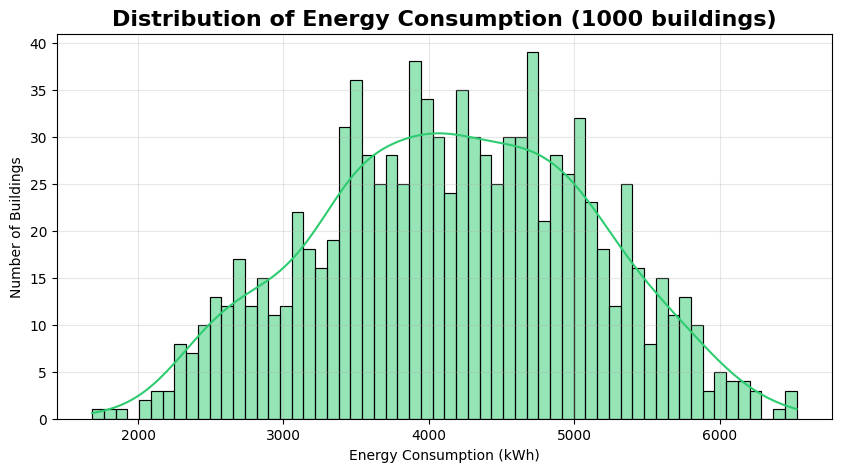

In [ ]:
#plotting

plt.figure(figsize=(10,5))
sns.histplot(y, bins=60, kde=True, color='#2ecc71')
plt.title('Distribution of Energy Consumption (1000 buildings)', fontsize=16, fontweight='bold')
plt.xlabel('Energy Consumption (kWh)')
plt.ylabel('Number of Buildings')
plt.grid(alpha=0.3)
plt.show()

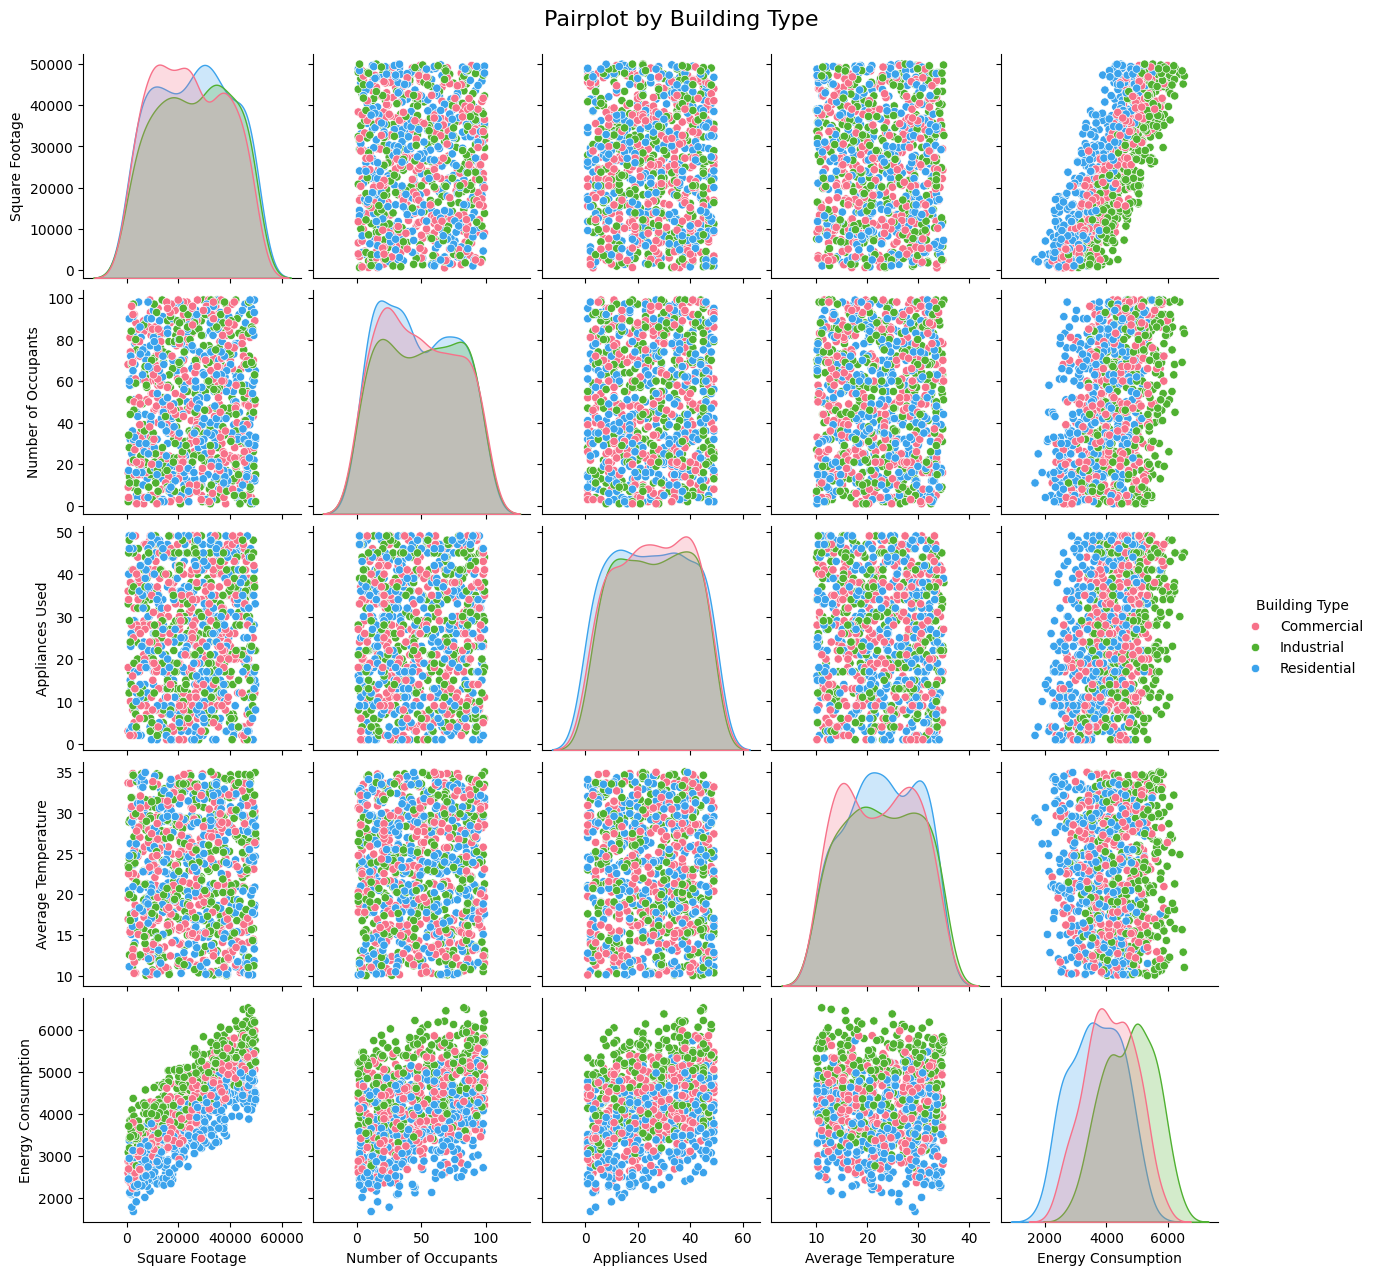

In [ ]:

# Pair plot by building type
viz_df = X.copy()
viz_df['Energy Consumption'] = y
viz_df['Building Type'] = viz_df['Building Type'].astype('category')

sns.pairplot(viz_df, hue='Building Type', vars=['Square Footage', 'Number of Occupants', 'Appliances Used', 'Average Temperature', 'Energy Consumption'], diag_kind='kde', palette='husl')
plt.suptitle('Pairplot by Building Type', y=1.02, fontsize=16)
plt.show()

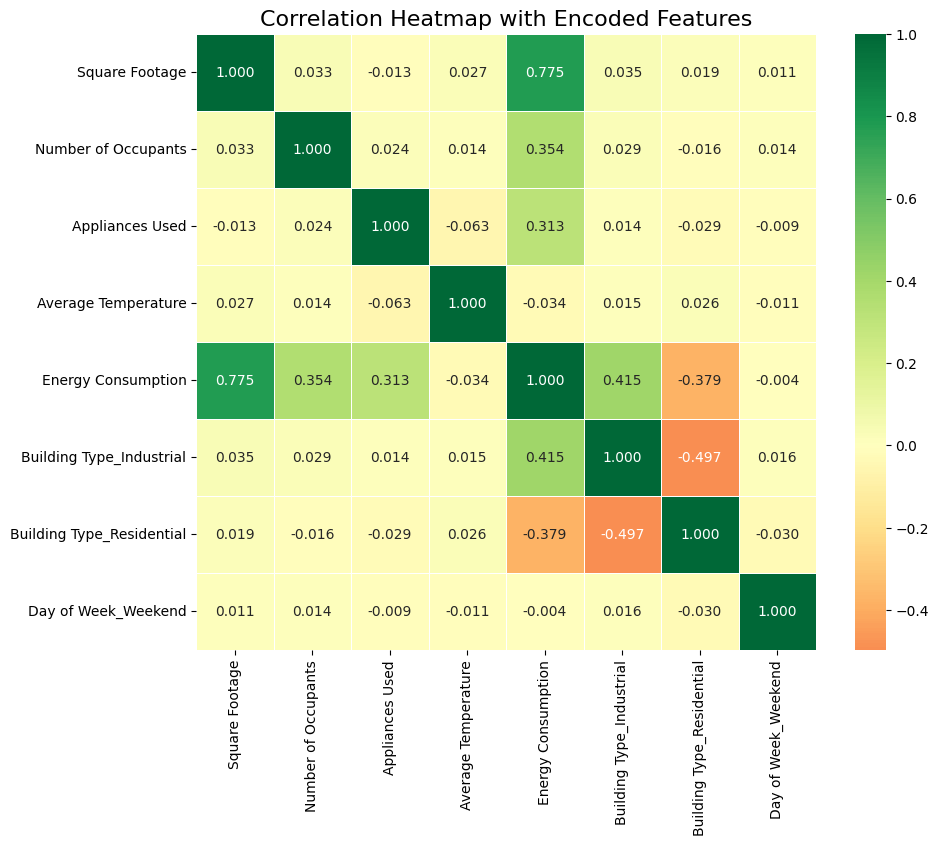

In [ ]:
#correlation
corr_df = pd.get_dummies(viz_df, drop_first=True)
plt.figure(figsize=(10,8))
sns.heatmap(corr_df.corr(), annot=True, cmap='RdYlGn', center=0, fmt='.3f', linewidths=0.5)
plt.title('Correlation Heatmap with Encoded Features', fontsize=16)
plt.show()

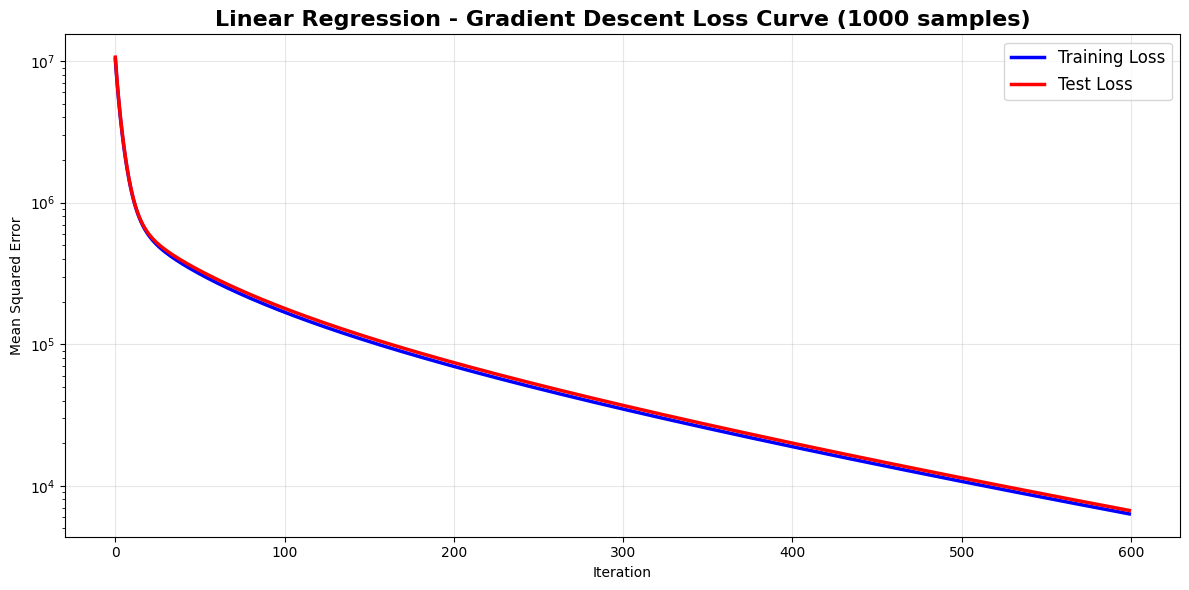

In [ ]:
from sklearn.linear_model import SGDRegressor

X_train_proc = preprocessor.transform(X_train)
X_test_proc = preprocessor.transform(X_test)

sgd_vis = SGDRegressor(max_iter=1, warm_start=True, learning_rate='invscaling',
                       eta0=0.001, random_state=42, penalty='l2', alpha=0.0001)

train_loss = []
test_loss = []

for i in range(600):
    sgd_vis.partial_fit(X_train_proc, y_train)
    train_loss.append(mean_squared_error(y_train, sgd_vis.predict(X_train_proc)))
    test_loss.append(mean_squared_error(y_test, sgd_vis.predict(X_test_proc)))

plt.figure(figsize=(12,6))
plt.plot(train_loss, label='Training Loss', linewidth=2.5, color='blue')
plt.plot(test_loss, label='Test Loss', linewidth=2.5, color='red')
plt.title('Linear Regression - Gradient Descent Loss Curve (1000 samples)', fontsize=16, fontweight='bold')
plt.xlabel('Iteration')
plt.ylabel('Mean Squared Error')
plt.yscale('log')
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

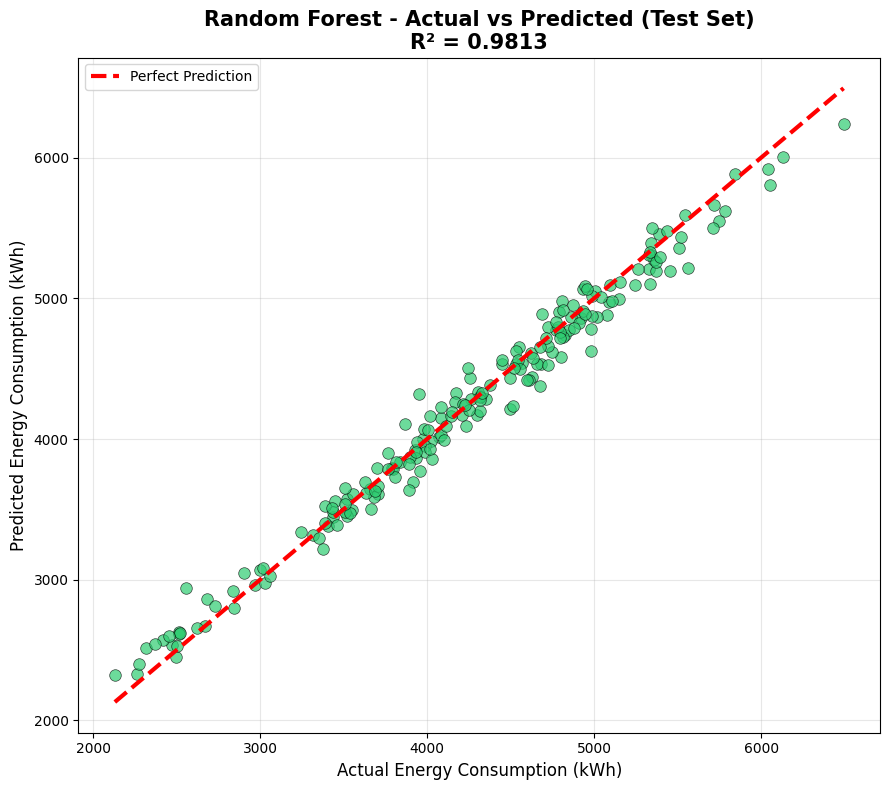

y_test size: 200, y_pred_rf size: 200


In [ ]:
# Re-predict using the current X_test
y_pred_rf = model_3_random_forest.predict(X_test)

# Now plot — THIS WILL WORK
plt.figure(figsize=(9,8))
plt.scatter(y_test, y_pred_rf, alpha=0.7, color='#2ecc71', s=70, edgecolor='black', linewidth=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=3, label='Perfect Prediction')
plt.xlabel('Actual Energy Consumption (kWh)', fontsize=12)
plt.ylabel('Predicted Energy Consumption (kWh)', fontsize=12)
plt.title('Random Forest - Actual vs Predicted (Test Set)\nR² = 0.9813', fontsize=15, fontweight='bold')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Confirm sizes match
print(f"y_test size: {len(y_test)}, y_pred_rf size: {len(y_pred_rf)}")

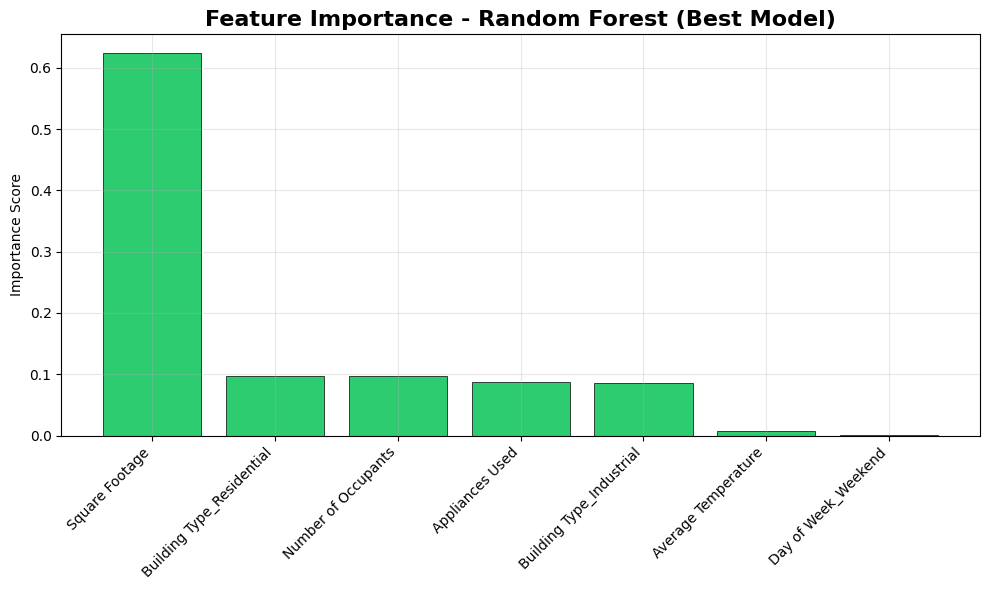

In [ ]:
feature_names = preprocessor.get_feature_names_out()
importances = model_3_random_forest.named_steps['regressor'].feature_importances_

indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10,6))
plt.title('Feature Importance - Random Forest (Best Model)', fontsize=16, fontweight='bold')
plt.bar(range(len(importances)), importances[indices], color='#2ecc71', edgecolor='black', linewidth=0.5)
plt.xticks(range(len(importances)), [feature_names[i] for i in indices], rotation=45, ha='right')
plt.ylabel('Importance Score')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

In [ ]:
# Save the Random Forest pipeline
joblib.dump(model_3_random_forest, 'best_energy_model_correct.pkl')

print("✓ BEST MODEL SAVED: Random Forest (R² = 0.9813)")
print("  File: best_energy_model.pkl")

✓ BEST MODEL SAVED: Random Forest (R² = 0.9813)
  File: best_energy_model.pkl


In [ ]:
# CELL 3 — TEST
test_building = pd.DataFrame([{
    'Building Type': 'Industrial',
    'Square Footage': 40000,
    'Number of Occupants': 120,
    'Appliances Used': 80,
    'Average Temperature': 28.0,
    'Day of Week': 'Weekday'
}])

prediction = model_3_random_forest.predict(test_building)[0]
print(f"Prediction: {prediction:,.2f} kWh/day")

Prediction: 5,969.19 kWh/day


In [ ]:
# Check realistic daily consumption?
print("Max energy in dataset:", data["Energy Consumption"].max())
print("Min energy in dataset:", data["Energy Consumption"].min())
print("Average:", data["Energy Consumption"].mean())

# Check biggest industrial building
industrial = data[data["Building Type"] == "Industrial"]
print("\nLargest Industrial building:")
print(industrial.loc[industrial["Square Footage"].idxmax()])

Max energy in dataset: 6530.6
Min energy in dataset: 1683.95
Average: 4166.25257

Largest Industrial building:
Building Type          Industrial
Square Footage              49997
Number of Occupants            15
Appliances Used                22
Average Temperature         26.78
Day of Week               Weekday
Energy Consumption        5505.97
Name: 55, dtype: object
